In [1]:
import sys
sys.path.append('..')
import torch
import numpy as np
import matplotlib.pyplot as plt
from HeatEquation_DeepHPM import HeatEquationHPMNet, load_checkpoint
from UKDDataset import HeatEquationHPMDataset, SchrodingerEquationDataset

In [2]:
def getDefaults():
    # static parameter
    nx = 640
    ny = 480
    nt = 300
    xmin = 0
    xmax = 1
    ymin = 0
    ymax = 1
    dt = 0.0017
    tmax = 1.9271e-04
    #numOfEnergySamplingPointsX = 100
    #numOfEnergySamplingPointsY = 100

    coordinateSystem = {"x_lb": xmin, "x_ub": xmax, "y_lb": ymin, "y_ub" : ymax, "nx":nx , "ny":ny, "tmax": tmax, "dt": dt}

    return coordinateSystem

In [3]:
import os
import h5py

def loadTimesteps(pFile):

    if not os.path.exists(pFile):
        raise FileNotFoundError('Could not find file' + pFile)

    hf = h5py.File(pFile, 'r')
    timing = np.array(hf['timing'][:])

    hf.close()
    
    timing = timing - np.min(timing)
    
    return timing

The following code initializes our models and loads a pretrained model from `pathModel`. 

In [4]:
pathModel = 'results/models/S2D_DeepHPM/0_ic/model_400.pt'
pathData = '../../data/UKD/2014_022_rest.mat'


coordinateSystem = getDefaults()

maxTime = np.max(loadTimesteps(pathData))
coordinateSystem["tMax"] = 1 / maxTime
print("tmax: %.4f" % (maxTime))


lb = np.array([coordinateSystem["x_lb"], coordinateSystem["y_lb"], 0.])
ub = np.array([coordinateSystem["x_ub"], coordinateSystem["y_ub"], coordinateSystem["tmax"]])
numFeatures = 300
numLayers = 8
numLayers_hpm = 8
numFeatures_hpm = 300


model = HeatEquationHPMNet(numLayers, numFeatures, numLayers_hpm, numFeatures_hpm, lb, ub,
                          5, 5, torch.tanh).cuda()

load_checkpoint(model, pathModel)

tmax: 0.0006


In [ ]:
Let's create a dataset object amd check the output of the neural network on a certain slice (index) of that 

In [5]:
numBatches = 800
batchSize = 307200
ds = HeatEquationHPMDataset(pathData, coordinateSystem, numBatches, batchSize, maxFrames=10, shuffle=False, useGPU=False)

In [27]:
x, y, t, Ex_u = ds.__getitem__(9)
Ex_u = Ex_u.reshape(640,480)

In [28]:
x = x.view(-1)
y = y.view(-1)
t = t.view(-1)
inputX = torch.stack([x, y, t], 1)
Ex_u_pred = model.forward(inputX.cuda()).view(-1)
Ex_u_pred = Ex_u_pred.cpu().detach().numpy().reshape(640,480)

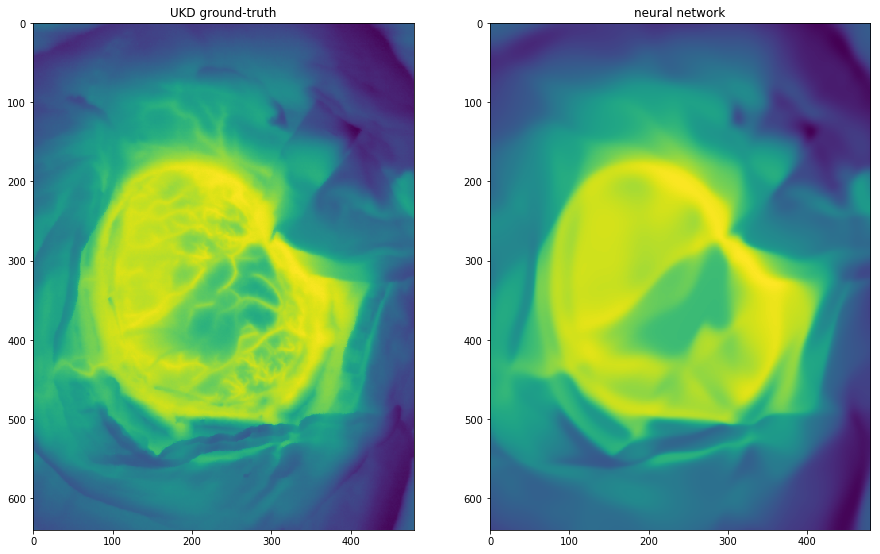

In [29]:
f, axarr = plt.subplots(1, 2, figsize=(15, 10))
cm = ['RdBu_r', 'viridis']

pcm = axarr[0].imshow(Ex_u)
axarr[0].set_title('UKD ground-truth')

pcm = axarr[1].imshow(Ex_u_pred)
axarr[1].set_title('neural network')

plt.show()